In [17]:
from SuperGluePretrainedNetwork.models.matching import Matching

import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"
config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': -1,
    },
    'superglue': {
        'weights': 'outdoor',
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2,
    }
}
matching = Matching(config).eval().to(device)
keys = ['keypoints', 'scores', 'descriptors']

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [3]:
def frame2tensor(frame, device):
    return torch.from_numpy(frame/255.).float()[None, None].to(device)

In [4]:
im_names = [os.path.join("./images",im) for im in os.listdir("./images")]

In [5]:
frame = cv2.imread(im_names[0], cv2.IMREAD_GRAYSCALE)
frame_tensor = frame2tensor(frame, device)
last_data = matching.superpoint({'image': frame_tensor})
last_data = {k+'0': last_data[k] for k in keys}
last_data['image0'] = frame_tensor
last_frame = frame
last_image_id = 0

for im_name in im_names[1:2]:
    frame = cv2.imread(im_name, cv2.IMREAD_GRAYSCALE)
    frame_tensor = frame2tensor(frame, device)
    
    pred = matching({**last_data, 'image1': frame_tensor})
    kpts0 = last_data['keypoints0'][0].cpu().numpy()
    kpts1 = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()
    confidence = pred['matching_scores0'][0].cpu().detach().numpy()
    
    valid = matches > -1
    mconfidence = confidence[valid]
    possible = mconfidence>0.95 
    
    mkpts0 = kpts0[valid]
    mkpts0 = mkpts0[possible]
    mkpts1 = kpts1[matches[valid]]
    mkpts1 = mkpts1[possible]

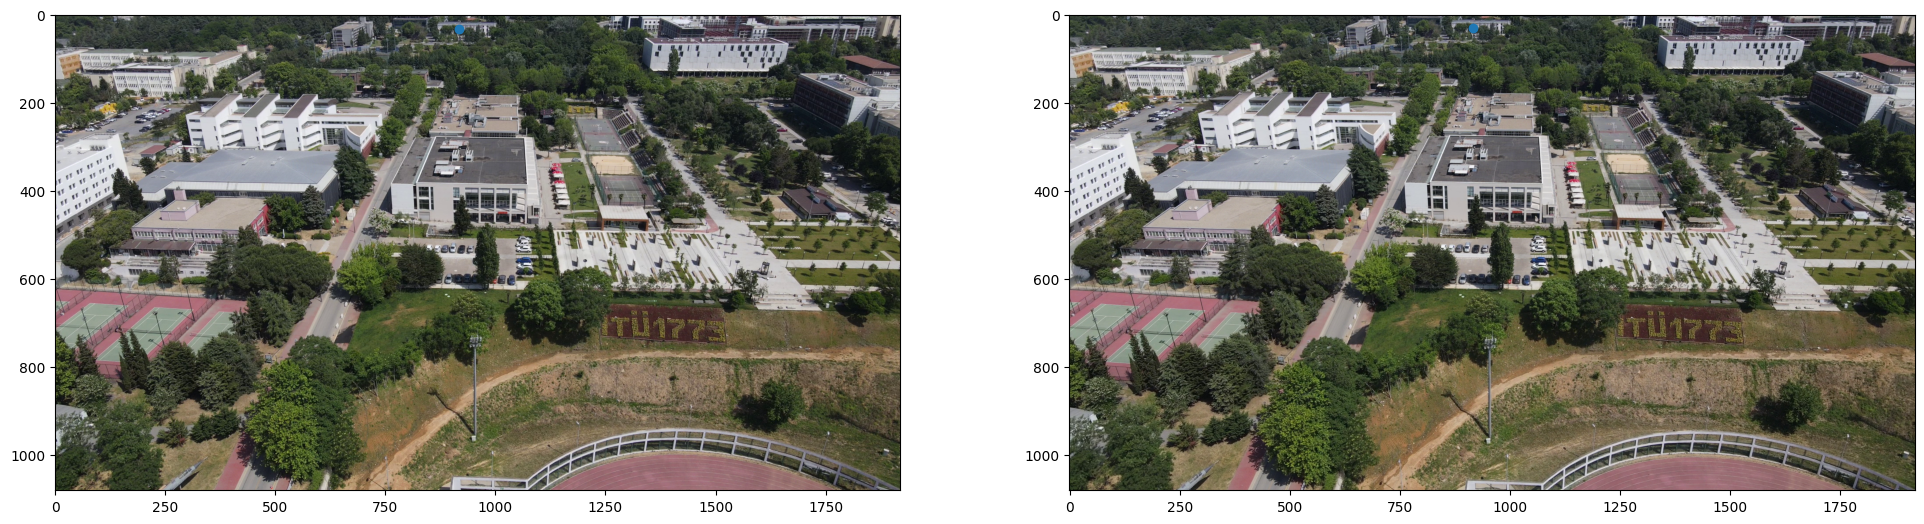

In [6]:
# mkpts0, mkpts1 = np.round(mkpts0).astype(int), np.round(mkpts1).astype(int)
fig, ax = plt.subplots(1,2, figsize=(24,8))
idx = 20
ax[0].imshow(cv2.imread(im_names[0])[:,:,::-1])
ax[0].plot(mkpts0[idx,0],mkpts0[idx,1],ls="", marker="o")

ax[1].imshow(cv2.imread(im_names[1])[:,:,::-1])
ax[1].plot(mkpts1[idx,0],mkpts1[idx,1],ls="", marker="o")


In [7]:
def normalize_points(K, points):
    K_inv = np.linalg.inv(K)
    normalized_points = cv2.convertPointsToHomogeneous(points)[:, 0, :].T
    normalized_points = K_inv @ normalized_points
    return normalized_points[:2].T  # Return x, y coordinates.

In [8]:
# Constants from metadata
focal_length_mm = 35.0  # Focal length in mm
x_resolution = 5798.66  # Pixels per inch
y_resolution = 5788.94  # Pixels per inch
image_width = 5184
image_height = 3456

# Conversion factor (1 inch = 25.4 mm)
pixels_per_mm_x = x_resolution / 25.4
pixels_per_mm_y = y_resolution / 25.4

# Focal length in pixels
f_x = focal_length_mm * pixels_per_mm_x
f_y = focal_length_mm * pixels_per_mm_y

# Principal point (assuming image center)
c_x = image_width / 2
c_y = image_height / 2

# Intrinsic matrix K
K = np.array([
    [f_x, 0, c_x],
    [0, f_y, c_y],
    [0,  0,  1]
])

In [9]:
normalized_points1 = normalize_points(K, mkpts0)
normalized_points2 = normalize_points(K, mkpts1)

E, mask = cv2.findEssentialMat(
    normalized_points1, normalized_points2, method=cv2.RANSAC, prob=0.999, threshold=1e-3
)

inlier_points1 = mkpts0[mask.ravel() == 1]
inlier_points2 = mkpts1[mask.ravel() == 1]

print("Essential Matrix:\n", E)
print(f"Number of inliers: {np.sum(mask)}")

Essential Matrix:
 [[ 8.75197448e-04 -6.98249084e-01 -9.56416800e-02]
 [ 6.98134183e-01  7.03470732e-04  5.87342587e-02]
 [ 9.57570903e-02 -5.73508631e-02  1.81257888e-04]]
Number of inliers: 3433


In [10]:
def decompose_essential_matrix(E):
    # Decomposing E into R and t
    R1, R2, t = cv2.decomposeEssentialMat(E)
    return R1, R2, t

R1, R2, t = decompose_essential_matrix(E)

# Print results
print("Rotation Matrix 1:\n", R1)
print("Rotation Matrix 2:\n", R2)
print("Translation Vector:\n", t)

# Camera poses to check (four combinations)
poses = [
    (R1, t),
    (R1, -t),
    (R2, t),
    (R2, -t),
]

Rotation Matrix 1:
 [[ 9.99997799e-01  1.00080978e-03  1.84418558e-03]
 [-1.00065836e-03  9.99999496e-01 -8.30277065e-05]
 [-1.84426775e-03  8.11821241e-05  9.99998296e-01]]
Rotation Matrix 2:
 [[-0.98652345  0.02098991 -0.16226803]
 [ 0.02344744 -0.96336539 -0.2671654 ]
 [-0.16193118 -0.2673697   0.94989038]]
Translation Vector:
 [[-0.08124186]
 [-0.13533998]
 [ 0.98746284]]


In [13]:
def triangulate(R, t, K, points1, points2):
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.hstack((R, t.reshape(-1, 1)))

    # Triangulate points
    points_4d_hom = cv2.triangulatePoints(P1, P2, points1.T, points2.T)
    points_3d = points_4d_hom[:3] / points_4d_hom[3]  # Convert to non-homogeneous
    return points_3d

def check_pose(R, t, K, points1, points2):
    points_3d = triangulate(R, t, K, points1, points2)

    # Check if points are in front of both cameras
    depths1 = points_3d[2]  # Depth for camera 1
    depths2 = (R @ points_3d + t.reshape(-1, 1))[2]  # Depth for camera 2

    return np.all(depths1 > 0) and np.all(depths2 > 0), points_3d.T

# Check all poses
for i, (R, t) in enumerate(poses):
    valid, points_3d = check_pose(R, t, K, inlier_points1[:500], inlier_points2[:500])
    if valid:
        print(f"Pose {i + 1} is valid")
        correct_R, correct_t = R, t
        break

# Print the correct pose
print("Correct Rotation:\n", correct_R)
print("Correct Translation:\n", correct_t)

Pose 2 is valid
Correct Rotation:
 [[ 9.99997799e-01  1.00080978e-03  1.84418558e-03]
 [-1.00065836e-03  9.99999496e-01 -8.30277065e-05]
 [-1.84426775e-03  8.11821241e-05  9.99998296e-01]]
Correct Translation:
 [[ 0.08124186]
 [ 0.13533998]
 [-0.98746284]]


In [22]:
points = triangulate(correct_R, correct_t, K, inlier_points1[:1000], inlier_points2[:1000])

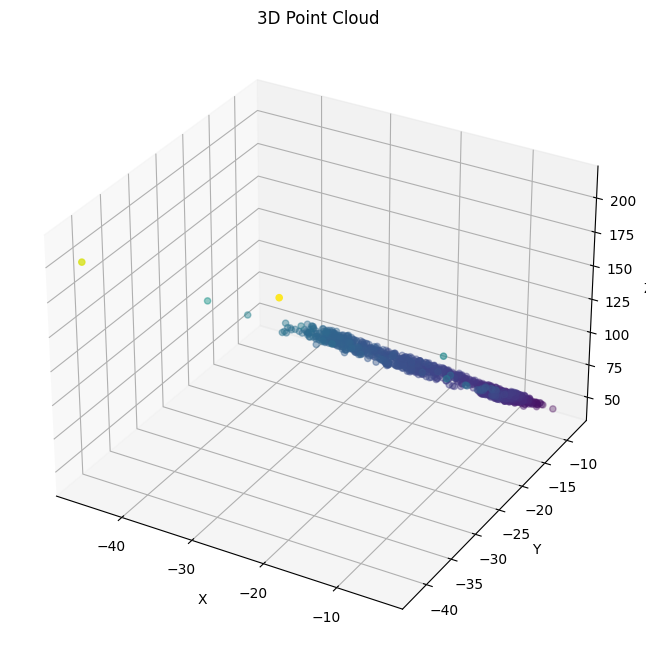

In [23]:
# Extract x, y, z coordinates
x = points[0, :]
y = points[1, :]
z = points[2, :]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

# Add labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Point Cloud")

plt.show()